Author: Raquel Peña

## HW1 : Distinguishing Apples from Background Using Gaussian Mixture Models

This notebook extends our exploration of fitting parametric models to visual data, with a focus on real-world applications.     

The primary objective of this part is to apply Gaussian mixture models to distinguish between apple and non-apple pixels in images. We will utilize the RGB color space as our feature dimensions.Additionally, we will test our model's performance on new data, quantify the results using ROC curves, and explore the implications of using separate data sets for training, validation, and testing to ensure our model's robustness and generalizability.

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

import glob
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib notebook


### 0. Functions
Some or the following functions are used in the Practical Mix Gauss.

In [2]:
#==========================================================================
#==========================================================================

def fitGaussianModel(data):
    """
    Returns the mean and covariance for a set of multidimensional data.
    It is assumed that each column of the 2D array, data, contains a single data point.
    The mean vector should be a dx1 vector with the mean value of the data. For this lab, the output is a
    3 by 1 vector containing the RGB mean of the input pixels. The covariance should be a dxd covariance
    matrix. See the note at the top, which explains that using mean() is ok,
    but please compute the covariance yourself.

    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions, and n is the number of data points.

    Returns:
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """

    nDim, nData = data.shape

    #TO DO (a): replace the placeholders for meanData and covData with the real equations.

    # Calculate mean of data. You can do this using the numpy command 'mean'.
    meanData = np.mean(data, axis=1, keepdims=True)

    # Calculate covariance of data. You should do this yourself to ensure you
    # understand how. Check you have the right answer by comparing with the
    # numpy function np.cov().
    data_centered = data - meanData
    covData = (1 / nData) * np.dot(data_centered, (data_centered.T))

    return meanData, covData


In [3]:
# The goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):   
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    # Calculate the inverse of the covariance matrix
    cov_inv = np.linalg.inv(gaussCov)

    # Calculate the determinant of the covariance matrix
    cov_det = np.linalg.det(gaussCov)


    # Calculate the difference between the data points and the mean for all data points
    x_minus_mean = data - gaussMean

    # Calculate the exponent term of the Gaussian likelihood for all data points
    exponent = -0.5 * np.sum(x_minus_mean * np.dot(cov_inv, x_minus_mean), axis=0)

    # Calculate the divisor term of the Gaussian likelihood for all data points
    divisor = 1.0 / (np.sqrt((2 * np.pi) ** nDim * cov_det))

    # Calculate the likelihood for all data points
    like = divisor * np.exp(exponent)

    return like

In [4]:
def calculate_tpr_fpr_vectorized(y_true, y_scores, thresholds):
    tpr_list = []
    fpr_list = []
    
    y_true = y_true.astype(bool)
    
    for threshold in thresholds:   # Set the threshold according of the min,max of the data
        y_pred = y_scores >= threshold
        TP = np.logical_and(y_pred, y_true).sum()   # Counts instances where prediction and truth are positive
        FP = np.logical_and(y_pred, ~y_true).sum()  # Counts instances where prediction is positive but truth is negative
        TN = np.logical_and(~y_pred, ~y_true).sum() # Counts instances where both prediction and truth are negative
        FN = np.logical_and(~y_pred, y_true).sum()  # Counts instances where prediction is negative but truth is positive
        
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    
    return np.array(fpr_list), np.array(tpr_list)

In [5]:
def calculate_auc(fpr, tpr):
    """ 
    Calculates the Area Under the Curve (AUC) for a ROC curve using the trapezoidal rule. This rule estimates the area
    by summing the areas of trapezoids beneath the curve which is plotted with false positive rates (fpr) on the x-axis
    and true positive rates (tpr) on the y-axis. It sorts the FPR values and computes the AUC as the integrated area
    using these sorted values.
    """
    
    # Sort the FPR and TPR values based on FPR in ascending order to ensure the monotonicity of the ROC 
    sorted_indices = np.argsort(fpr)
    sorted_fpr = fpr[sorted_indices]
    sorted_tpr = tpr[sorted_indices]
    
    # Calculate the AUC using the trapezoidal rule
    area = np.trapz(sorted_tpr, sorted_fpr)
    return area

In [26]:
def calculate_precision_recall_f1_specificity(y_true, y_pred):
    """
    Calculates precision, recall, F1 Score, and specificity for the given predictions.
    - Precision measures the accuracy of positive predictions.
    - Recall (sensitivity) measures the fraction of positives that were correctly identified.
    - F1 Score is the harmonic mean of precision and recall.
    - Specificity measures the fraction of true negatives that were correctly identified.
    """

    # Calculate True Positives, False Positives, False Negatives, and True Negatives
    TP = np.logical_and(y_pred == 1, y_true == 1).sum()
    FP = np.logical_and(y_pred == 1, y_true == 0).sum()
    FN = np.logical_and(y_pred == 0, y_true == 1).sum()
    TN = np.logical_and(y_pred == 0, y_true == 0).sum()

    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0

    # Calculate recall
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return precision, recall, f1_score, specificity

### A. Download and unzip the file apples.zip. and ussing a threshold

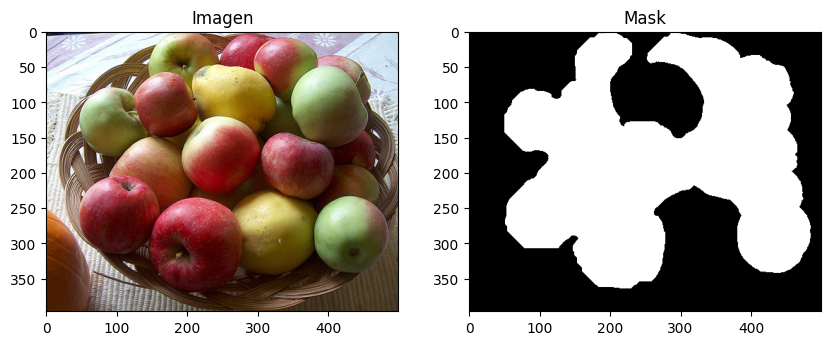

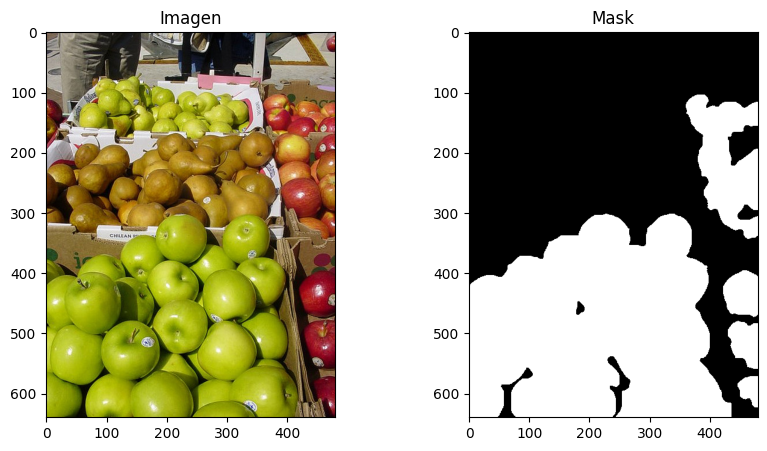

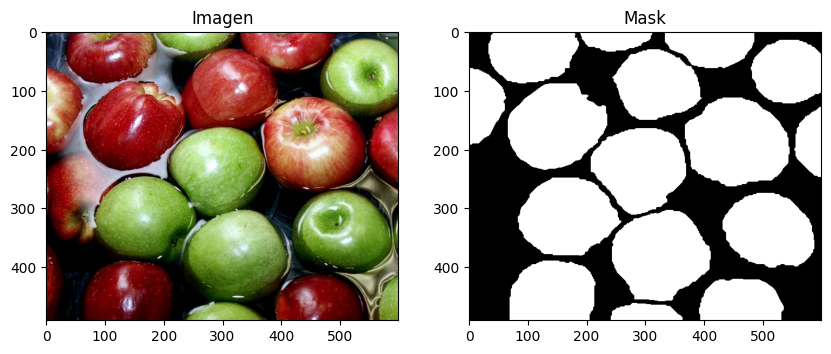

In [6]:
%matplotlib inline

# Define the paths to your image and mask files
image_paths = [
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/train/Apples_by_kightp_Pat_Knight_flickr.jpg",
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/train/ApplesAndPears_by_srqpix_ClydeRobinson.jpg",
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/train/bobbing-for-apples.jpg"
]


mask_paths = [
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/train/Apples_by_kightp_Pat_Knight_flickr.png",
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/train/ApplesAndPears_by_srqpix_ClydeRobinson.png",
    "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/train/bobbing-for-apples.png"
]

# Initialize lists for storing apple and non apple pixels
# Assumption: Images contain distinguishable apple areas that can be separated by mask
apple_pixels = []
non_apple_pixels = []

# Carga y procesamiento de imágenes y máscaras
for img_path, mask_path in zip(image_paths, mask_paths):
    # Load the image
    img = Image.open(img_path)
    img_np = np.array(img) / 255.0  # Normaliza a [0, 1] si es necesario
    
    # Load the mask
    mask = Image.open(mask_path)
    mask_np = np.array(mask)
    
    # If the mask is RGBA, take only the R channel for the binary mask
    # Assumption: In RGBA masks, the red channel (R) is used for marking apples
    if mask_np.shape[-1] == 4:  
        mask_binary = mask_np[:, :, 0] == 255
    else:  # If the mask is RGB or grayscale, assume white is represented by 255.For RGB or grayscale masks, white color (255) marks the apple areas
        mask_binary = np.all(mask_np == [255, 255, 255], axis=-1) if mask_np.ndim == 3 else (mask_np == 255)
    
    # Extract apple and non apple pixels
    apple_pixels.extend(img_np[mask_binary].reshape(-1, 3))
    non_apple_pixels.extend(img_np[~mask_binary].reshape(-1, 3))

    # Shows the figures and the masks
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title('Imagen')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_binary, cmap='gray')
    plt.title('Mask')
    
    plt.show()

In [7]:
# Convert list to arrays to execute
apple_pixels_np     = np.array(apple_pixels)
non_apple_pixels_np = np.array(non_apple_pixels)

In [8]:
# Check de dimension
apple_pixels_np.shape

(424647, 3)

In [9]:
non_apple_pixels_np.shape

(375653, 3)

### B. Use mixtures of Gaussians to distinguish apple vs. non-apple pixels.

In [10]:
# Calculate Gaussian model for apple pixels
mean_apple, cov_apple = fitGaussianModel(apple_pixels_np.T)  # Transpose to make each column a data point

# Calculate Gaussian model for non apple pixels
mean_non_apple, cov_non_apple = fitGaussianModel(non_apple_pixels_np.T)  # Transpose for the same reason


print("Mean of apples:", mean_apple)
print("Covariance of apples:", cov_apple)
print("Mean of non-apples:", mean_non_apple)
print("Covariance of non-apples:", cov_non_apple)

# These print statements provide the calculated mean and covariance matrices for both apple and non-apple pixels. 
# The mean represents the average color, while the covariance indicates the spread and correlation of color channels (RGB) in the data.

Mean of apples: [[0.56401989]
 [0.45508903]
 [0.2091386 ]]
Covariance of apples: [[0.03923555 0.03543416 0.02990884]
 [0.03543416 0.08432331 0.03788462]
 [0.02990884 0.03788462 0.05070164]]
Mean of non-apples: [[0.45219376]
 [0.38410755]
 [0.26531349]]
Covariance of non-apples: [[0.07844556 0.07496912 0.06187113]
 [0.07496912 0.08288524 0.07104687]
 [0.06187113 0.07104687 0.08668794]]


In [11]:
# Calculate the total number of apple and non-apple pixels in the training set
total_apple_pixels = len(apple_pixels_np)
total_non_apple_pixels = len(non_apple_pixels_np)
# This will be used to compute the prior probabilities

# The prior probabilities are calculated based on the frequentist approach, where the probability is based on 
# the observed frequency of events (pixels being apple or not).
prior_apple = total_apple_pixels / (total_apple_pixels + total_non_apple_pixels)
prior_non_apple = total_non_apple_pixels / (total_apple_pixels + total_non_apple_pixels)

# Print the prior probabilities
print(f'Prior probability of apple: {prior_apple}')
print(f'Prior probability of non-apple: {prior_non_apple}')

Prior probability of apple: 0.530609771335749
Prior probability of non-apple: 0.4693902286642509


We use a Gaussian Mixture Model approach to classify pixels as apple or non apple based on their RGB color values (3 dimensions). The prior probabilities calculated using the frequentist approach inform the likelihood of a pixel belonging to either class before observing its color. The mean and covariance calculations for each class (apple and non apple) help in modeling the distribution of colors associated with each class.

### C. Download the file testApples.zip. Generate figures for your notebook, showing each pixel’s posterior probability of being “apple"

C:\Users\rache\AppData\Local\Temp\ipykernel_7292\3933483612.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple[y, x] = (like_apple * prior_apple) / (like_apple * prior_apple + like_non_apple * prior_non_apple)


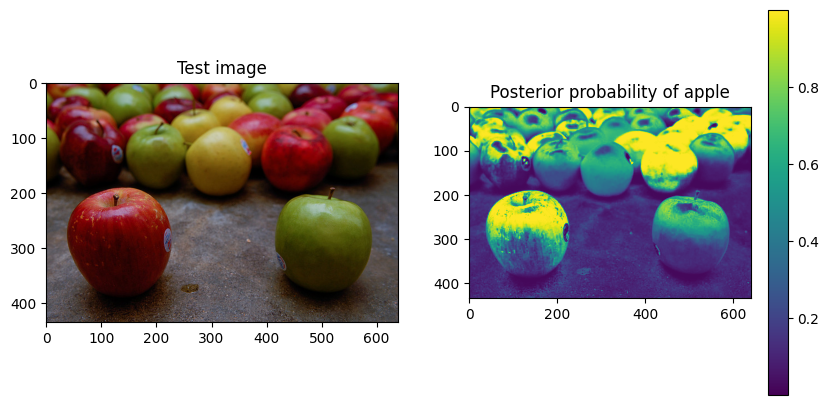

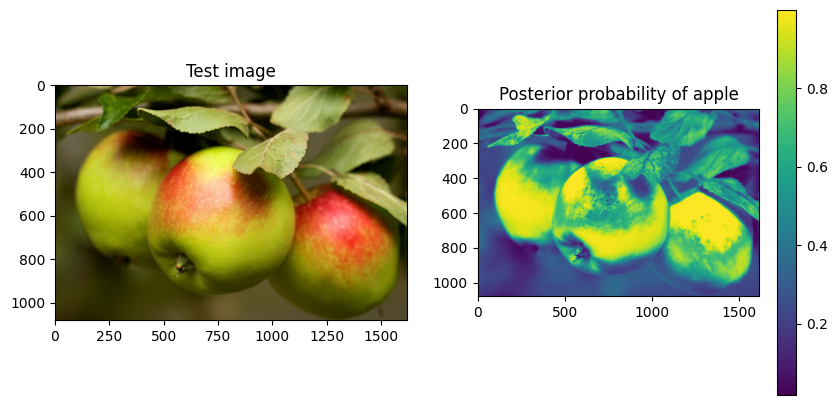

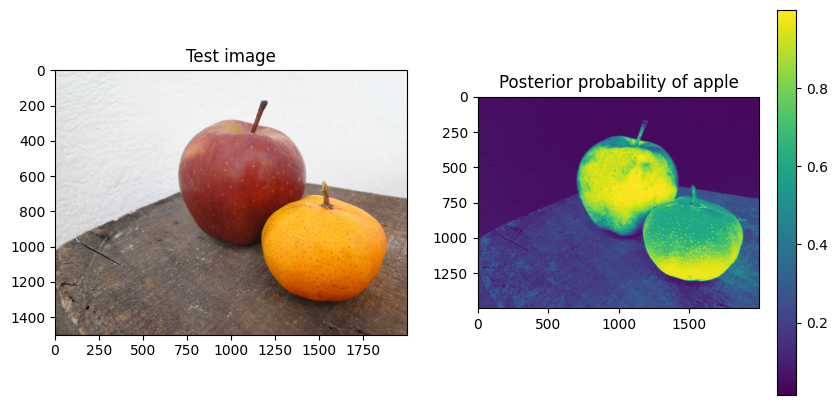

In [12]:
%matplotlib inline

test_image_dir = "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/test/"

# The glob module is used to find all the pathnames matching the specified pattern.
test_image_paths = glob.glob(test_image_dir + "*.jpg")

for test_image_path in test_image_paths:
    # Image is normalized to a range of [0, 1]. 
    # Dividing by 255 is a normalization step that converts pixel values from a range of 0-255 to a float point range of 0.0-1.0
    test_image_pil = Image.open(test_image_path)
    test_image = np.array(test_image_pil) / 255.0  
    
    # Just in case to ensure our dimension, it converts from RGBA to RGB 
    if test_image.ndim == 3 and test_image.shape[2] == 4:
        test_image = test_image[:, :, :3]

    # The matrix has the same height and width as the image
    posterior_apple = np.zeros(test_image.shape[:2]) 

    # Calculate the posterior probability for each pixel
    # Loop through each pixel in the image to calculate its posterior 
    for y in range(test_image.shape[0]):
        for x in range(test_image.shape[1]):
            # Extract the current pixel. Reshape the pixel to a column vector for the probability calculation
            this_pixel_data = test_image[y, x, :].reshape(3, 1)  

            # Calculate the likelihood of this pixel under apple and non-apple models using the Gaussian probability function.
            like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
            like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)

            # Calculate the posterior probability using Bayes' rule
            posterior_apple[y, x] = (like_apple * prior_apple) / (like_apple * prior_apple + like_non_apple * prior_non_apple)

    
    # Display the original image and the posterior probability
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Test image')
    plt.subplot(1, 2, 2)
    plt.imshow(posterior_apple)
    plt.title('Posterior probability of apple')
    plt.colorbar()  # Adds a color bar to interpret the probabilities
    plt.show()

The visualization  represents the posterior probability of each pixel belonging to an apple using a colormap scale.  In this heatmap, blue indicates lower probabilities suggesting non apple regions and yellow indicates higher probabilities pointing towards apple regions. The clear demarcation shows the model's confidence in distinguishing apple pixels from the background.

Analizing each of the images:
- First image:. The provided test image reveals the model's proficiency in distinguishing red apples, yet it exhibits challenges when it comes to green and yellow apples. This discrepancy likely arises from the limited representation of yellow apples in the training data. For green apples, the model's exposure during training was typically to clusters of green, which might confuse it in scenarios where green apples are interspersed with red and yellow ones. The background diversity and the sheen on the green apples seem to be interfering with accurate identification. Incorporating a broader range of training examples featuring green and yellow apples in varied settings could enhance the model's recognition capabilities.

- Second image: The model successfully identifies green apples with high probability, which can be attributed to the clear background and absence of other color tones around them. However, it incorrectly associates regions of leaves with apples, indicating a lack of training on leaf patterns. Similarly, the red spots on the apples and their shadows are assigned a lower probability of being apples, likely due to the model not having learned from such examples during training. This suggests that incorporating more diverse training samples, including apples with varying shades and surrounded by foliage, might improve model performance.

- Third image: In the test image, the red apple is accurately identified by the model with high probability. However, it confuses certain areas of the orange with an apple, which may be due to not having learned that an orange should be classified as non-apple, particularly in the areas where the orange has a smooth surface. Training the model with a wider variety of fruits could help it to better distinguish between different types of round fruits.

### D) For the test image with a ground-truth mask, quantify and report your result. 
Hint: consider applying a range of thresholds to the posterior to produce sets of {True Positives
(TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)} and using an
ROC curve.

In [20]:
# Load the test image and ground truth mask
test_image_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder\photos_apple/test/Bbr98ad4z0A-ctgXo3gdwu8-original.jpg'
ground_truth_mask_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/test/Bbr98ad4z0A-ctgXo3gdwu8-original.png'

test_image = Image.open(test_image_path)
ground_truth_mask = Image.open(ground_truth_mask_path)

# Convert to NumPy arrays
test_image_np = np.array(test_image)
ground_truth_mask_np = np.array(ground_truth_mask)

# Verify dimensions
print('Image:', test_image_np.shape)
print('Mask:', ground_truth_mask_np.shape)

# Flatten the test image for pixel-wise processing
# This converts the 2D image into a 1D array of pixels
test_image_flatten = test_image_np.reshape(-1, 3) / 255.0

# Prerequisites: mean_apple, cov_apple, mean_non_apple, cov_non_apple, prior_apple, prior_non_apple must be defined previously. 
# The prior is not going to change because we want to test with the trained examples.

# Initialize the array for posterior probabilities
posterior_apple_flatten = np.zeros(test_image_flatten.shape[0])

# Calculate the posterior probability for each pixel
for i in range(test_image_flatten.shape[0]):
    this_pixel_data = test_image_flatten[i, :].reshape(-1, 1)
    like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
    like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)
    posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))

# Convert the ground truth mask to grayscale and flatten, this creates a 1D array of binary values (0 or 1) from the grayscale mask
ground_truth_mask_grey = ground_truth_mask.convert('L')
ground_truth_mask_flatten = np.array(ground_truth_mask_grey).flatten()

# Normalize the ground truth mask to contain only 0 or 1 values
ground_truth_binary_flatten = (ground_truth_mask_flatten / 255).astype(int)

Image: (1500, 2000, 3)
Mask: (1500, 2000, 3)


C:\Users\rache\AppData\Local\Temp\ipykernel_7292\2326415869.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))


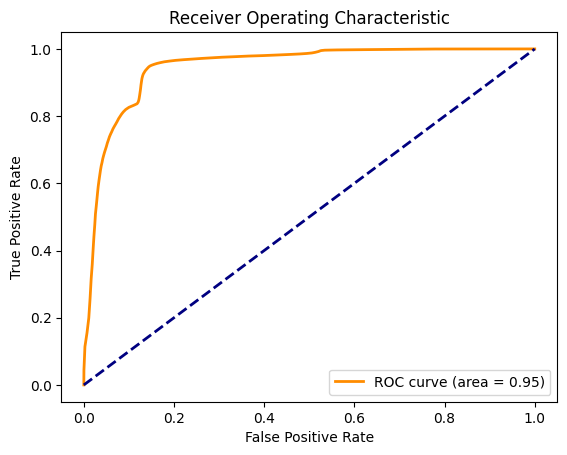

In [21]:
# To evaluate the classification: AUC ROC
# Select thresholds for calculating TPR and FPR
unique_scores = np.sort(np.unique(posterior_apple_flatten))
thresholds = np.linspace(unique_scores.min(), unique_scores.max(), 100)

# Calculate TPR and FPR at each threshold
fpr, tpr = calculate_tpr_fpr_vectorized(ground_truth_binary_flatten, posterior_apple_flatten, thresholds)

# Calculate AUC
auc = calculate_auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
auc

0.9457294891540245

In [27]:
# Another metrics 
# Define a threshold for classification
y_pred = (posterior_apple_flatten >= 0.5).astype(int)
precision, recall, f1_score, specificity = calculate_precision_recall_f1_specificity(ground_truth_binary_flatten, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Specificity: {specificity}')

Precision: 0.5069128700009279
Recall: 0.8826490991249237
F1 Score: 0.6439816258394239
Specificity: 0.8740691872602974


The model demonstrates a high overall accuracy of 95%, as indicated by the AUCROC, a high AUCROC score suggests that the model has a good measure of separability and is capable of distinguishing between positive and negative classes effectively, which suggests **good performance in general** predictions for this test. However, in classification problems, such exceptionally high metrics can sometimes be questionable. When examining the test image used to evaluate the model, we notice a significant black area in the mask, indicating a substantial presence of non-apple objects; this hints at a class imbalance in our dataset.

Due to this imbalance, it's essential to consider other classification metrics. Precision is a key metric as it tells us how many of the identified apples were actually apples. Unfortunately, only 51% of the apples were correctly classified. In contrast, specificity indicates that 87.4% of non-apples were correctly classified.In summary, the model performs well in classifying non-apple objects but struggles with apple classification in this case. Therefore, caution is necessary when making decisions based on apple classification due to its limited performance in this area. Let´s see what happen with other kind of figures not seen by the model, i.e out of sample.

### E) Extra Test examples : Download or snap two non-copyrighted photos with apples 
(maybe http://search.creativecommons.org/ or some other source of images that are not copyrighted).
Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated
programs like Gimp (free). Use these as extra test-images. Report your qualitative and
quantitative results.

C:\Users\rache\AppData\Local\Temp\ipykernel_7292\4211838722.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple[y, x] = (like_apple * prior_apple) / (like_apple * prior_apple + like_non_apple * prior_non_apple)


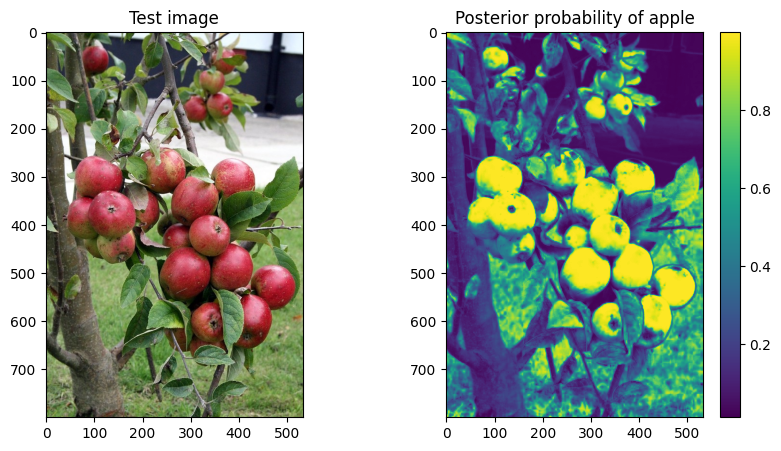

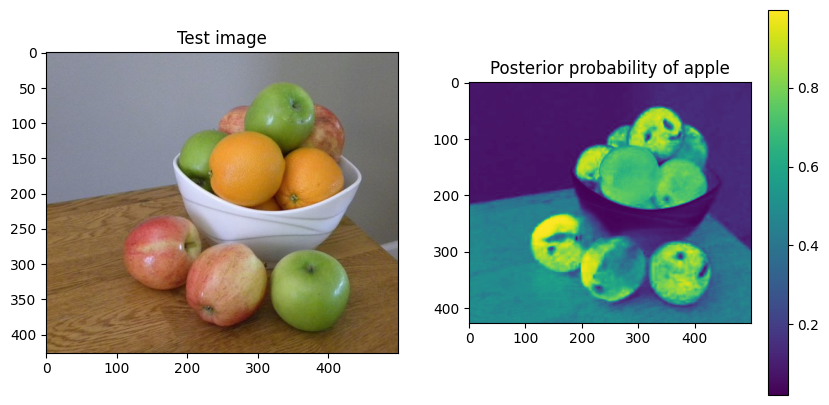

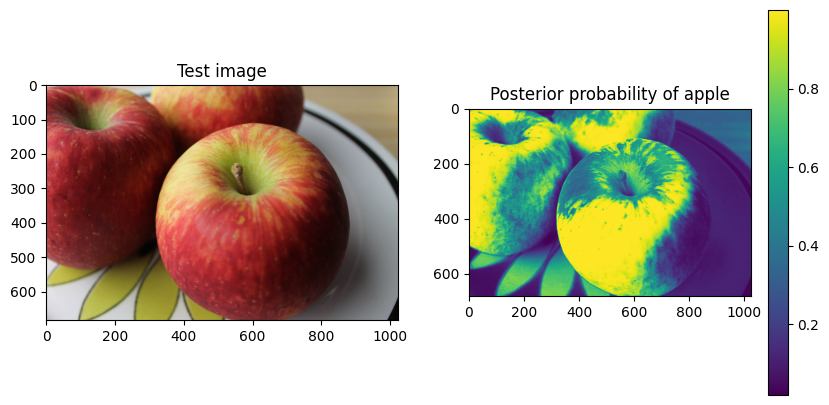

In [35]:
%matplotlib inline

# Define the path to the directory with out of sample images
test_image_dir = "C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/oos/"

# Path
test_image_paths = glob.glob(test_image_dir + "*.jpg")

# Iterate over the test images
for test_image_path in test_image_paths:
    # Load the test image with Pillow and convert it to a Numpy array
    test_image_pil = Image.open(test_image_path)
    test_image = np.array(test_image_pil) / 255.0  # Normalize if necessary
    
    # Ensure the image is in RGB format
    if test_image.ndim == 3 and test_image.shape[2] == 4:
        # Convert from RGBA to RGB if needed
        test_image = test_image[:, :, :3]

    # Initialize the posterior probability matrix
    posterior_apple = np.zeros(test_image.shape[:2])  # Assumes the image has dimensions [height, width]

    # Calculate the posterior probability for each pixel
    for y in range(test_image.shape[0]):
        for x in range(test_image.shape[1]):
            # Extract the current pixel
            this_pixel_data = test_image[y, x, :].reshape(3, 1)  # Ensure it's a column vector

            # Calculate likelihood for this pixel under apple and non-apple models
            like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
            like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)

            # Calculate posterior probability using Bayes' rule
            posterior_apple[y, x] = (like_apple * prior_apple) / (like_apple * prior_apple + like_non_apple * prior_non_apple)

    
    # Display the original image and the posterior probability
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title('Test image')
    plt.subplot(1, 2, 2)
    plt.imshow(posterior_apple
               #, #cmap='jet'
               )
    plt.title('Posterior probability of apple')
    plt.colorbar()
    plt.show()

In general, in the out-of-sample images, something very similar to what was observed in the test is happening, that is the result to not training with apples surrounded by leaves. Similarly, apples with varying shades on their surface tend to have a low probability (blue color) of being recognized as apples, this is once again because there were no examples of such apples in the training data. On the other hand, green apples are being correctly identified here, as they are less affected by surrounding colors. Lastly, when it comes to oranges, the model correctly classifies them as "non-apples" since they have a rougher surface.

In summary, the model **accurately** classifies apples that are entirely red in color, as well as bright green apples. Now, we will proceed to obtain quantitative results to assess how well the model performs in predicting apples

#### Image 1

Image: (800, 533, 3)
Mask: (800, 533, 3)


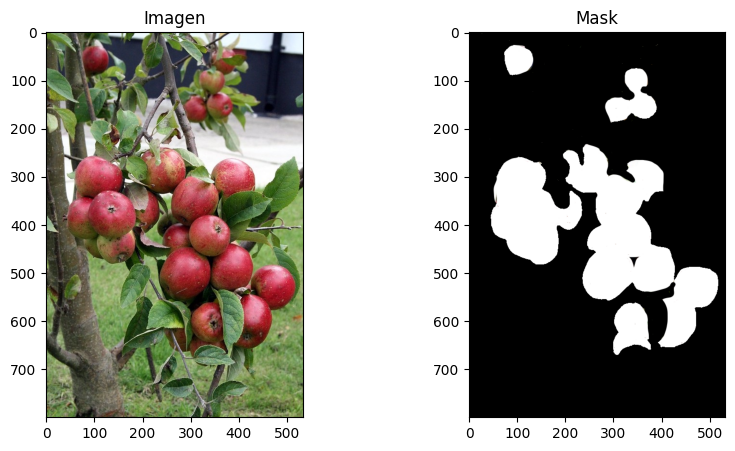

C:\Users\rache\AppData\Local\Temp\ipykernel_7292\3076046002.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))


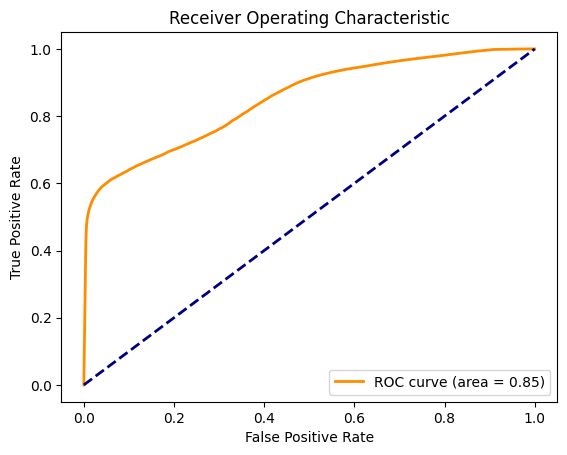

In [40]:
###### Image 1 ######
# Load the test image and ground truth mask
test_image_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/oos/truth_image1.jpg'
ground_truth_mask_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/oos/mask_image1.png'

test_image = Image.open(test_image_path)
ground_truth_mask = Image.open(ground_truth_mask_path)

# Convert to NumPy arrays
test_image_np = np.array(test_image)
ground_truth_mask_np = np.array(ground_truth_mask)

# Verify dimensions
print('Image:', test_image_np.shape)
print('Mask:', ground_truth_mask_np.shape)

# Shows image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_np)
plt.title('Imagen')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_mask_np, cmap='gray')
plt.title('Mask')
plt.show()

# Flatten the test image for pixel-wise processing
# This converts the 2D image into a 1D array of pixels
test_image_flatten = test_image_np.reshape(-1, 3) / 255.0

# Prerequisites: mean_apple, cov_apple, mean_non_apple, cov_non_apple, prior_apple, prior_non_apple must be defined previously. 
# The prior is not going to change because we want to test with the trained examples.

# Initialize the array for posterior probabilities
posterior_apple_flatten = np.zeros(test_image_flatten.shape[0])

# Calculate the posterior probability for each pixel
for i in range(test_image_flatten.shape[0]):
    this_pixel_data = test_image_flatten[i, :].reshape(-1, 1)
    like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
    like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)
    posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))

# Convert the ground truth mask to grayscale and flatten, this creates a 1D array of binary values (0 or 1) from the grayscale mask
ground_truth_mask_grey = ground_truth_mask.convert('L')
ground_truth_mask_flatten = np.array(ground_truth_mask_grey).flatten()

# Normalize the ground truth mask to contain only 0 or 1 values
ground_truth_binary_flatten = (ground_truth_mask_flatten / 255).astype(int)

################# Evaluate #################
# To evaluate the classification: AUC ROC
# Select thresholds for calculating TPR and FPR
unique_scores = np.sort(np.unique(posterior_apple_flatten))
thresholds = np.linspace(unique_scores.min(), unique_scores.max(), 100)

# Calculate TPR and FPR at each threshold
fpr, tpr = calculate_tpr_fpr_vectorized(ground_truth_binary_flatten, posterior_apple_flatten, thresholds)

# Calculate AUC
auc = calculate_auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [41]:
# Another metrics 
# Define a threshold for classification
y_pred = (posterior_apple_flatten >= 0.5).astype(int)
precision, recall, f1_score, specificity = calculate_precision_recall_f1_specificity(ground_truth_binary_flatten, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Specificity: {specificity}')

Precision: 0.4346216950765878
Recall: 0.7418892772771489
F1 Score: 0.5481311824984698
Specificity: 0.7287585135691346


#### Image 2

Image: (426, 500, 3)
Mask: (426, 500, 3)


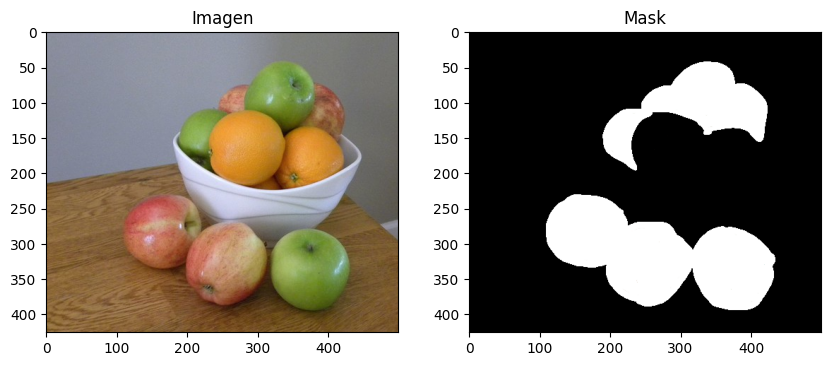

C:\Users\rache\AppData\Local\Temp\ipykernel_7292\3081816241.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))


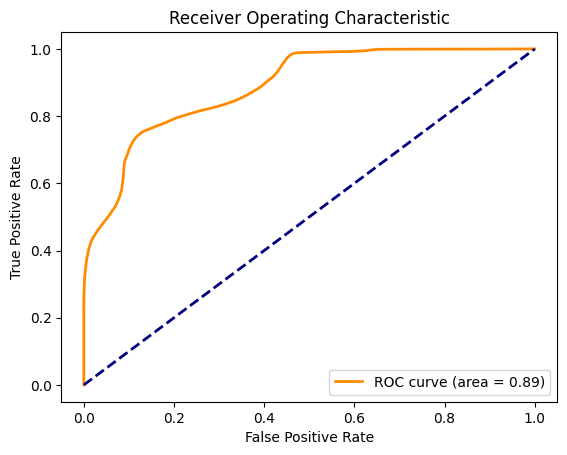

In [42]:
###### Image 2 ######
# Load the test image and ground truth mask
test_image_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/oos/truth_image2.jpg'
ground_truth_mask_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/oos/mask_image2.png'

test_image = Image.open(test_image_path)
ground_truth_mask = Image.open(ground_truth_mask_path)

# Convert to NumPy arrays
test_image_np = np.array(test_image)
ground_truth_mask_np = np.array(ground_truth_mask)

# Verify dimensions
print('Image:', test_image_np.shape)
print('Mask:', ground_truth_mask_np.shape)

# Shows image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_np)
plt.title('Imagen')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_mask_np, cmap='gray')
plt.title('Mask')
plt.show()

# Flatten the test image for pixel-wise processing
# This converts the 2D image into a 1D array of pixels
test_image_flatten = test_image_np.reshape(-1, 3) / 255.0

# Prerequisites: mean_apple, cov_apple, mean_non_apple, cov_non_apple, prior_apple, prior_non_apple must be defined previously. 
# The prior is not going to change because we want to test with the trained examples.

# Initialize the array for posterior probabilities
posterior_apple_flatten = np.zeros(test_image_flatten.shape[0])

# Calculate the posterior probability for each pixel
for i in range(test_image_flatten.shape[0]):
    this_pixel_data = test_image_flatten[i, :].reshape(-1, 1)
    like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
    like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)
    posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))

# Convert the ground truth mask to grayscale and flatten, this creates a 1D array of binary values (0 or 1) from the grayscale mask
ground_truth_mask_grey = ground_truth_mask.convert('L')
ground_truth_mask_flatten = np.array(ground_truth_mask_grey).flatten()

# Normalize the ground truth mask to contain only 0 or 1 values
ground_truth_binary_flatten = (ground_truth_mask_flatten / 255).astype(int)

################# Evaluate #################
# To evaluate the classification: AUC ROC
# Select thresholds for calculating TPR and FPR
unique_scores = np.sort(np.unique(posterior_apple_flatten))
thresholds = np.linspace(unique_scores.min(), unique_scores.max(), 100)

# Calculate TPR and FPR at each threshold
fpr, tpr = calculate_tpr_fpr_vectorized(ground_truth_binary_flatten, posterior_apple_flatten, thresholds)

# Calculate AUC
auc = calculate_auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [43]:
# Another metrics 
y_pred = (posterior_apple_flatten >= 0.5).astype(int)
precision, recall, f1_score, specificity = calculate_precision_recall_f1_specificity(ground_truth_binary_flatten, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Specificity: {specificity}')

Precision: 0.5999344409364594
Recall: 0.7586778662594087
F1 Score: 0.6700321778839669
Specificity: 0.8612807704962163


#### Image 3

Image: (683, 1024, 3)
Mask: (683, 1024, 3)


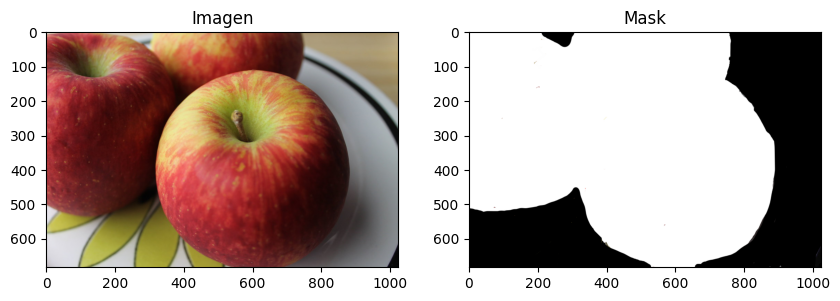

C:\Users\rache\AppData\Local\Temp\ipykernel_7292\3127821794.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))


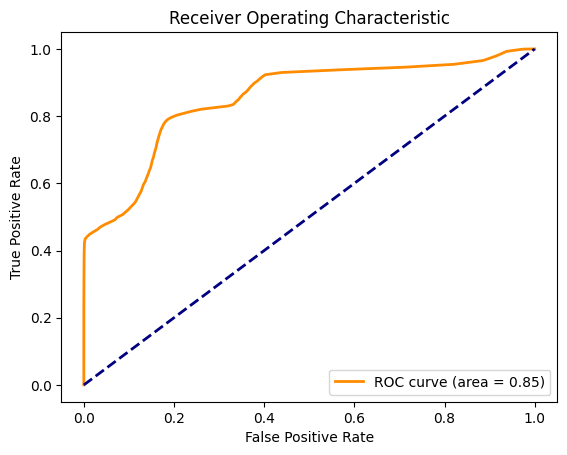

In [44]:
###### Image 3 ######
# Load the test image and ground truth mask
test_image_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/photos_apple/oos/truth_image3.jpg'
ground_truth_mask_path = 'C:/Users/rache/OneDrive/Documentos/MSc Data Science & Machine Learning/Term1/Machine Vision/HW1/HW1_submissionfolder/mask_apple/oos/mask_image3.png'

test_image = Image.open(test_image_path)
ground_truth_mask = Image.open(ground_truth_mask_path)

# Convert to NumPy arrays
test_image_np = np.array(test_image)
ground_truth_mask_np = np.array(ground_truth_mask)

# Verify dimensions
print('Image:', test_image_np.shape)
print('Mask:', ground_truth_mask_np.shape)

# Shows image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image_np)
plt.title('Imagen')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth_mask_np, cmap='gray')
plt.title('Mask')
plt.show()

# Flatten the test image for pixel-wise processing
# This converts the 2D image into a 1D array of pixels
test_image_flatten = test_image_np.reshape(-1, 3) / 255.0

# Prerequisites: mean_apple, cov_apple, mean_non_apple, cov_non_apple, prior_apple, prior_non_apple must be defined previously. 
# The prior is not going to change because we want to test with the trained examples.

# Initialize the array for posterior probabilities
posterior_apple_flatten = np.zeros(test_image_flatten.shape[0])

# Calculate the posterior probability for each pixel
for i in range(test_image_flatten.shape[0]):
    this_pixel_data = test_image_flatten[i, :].reshape(-1, 1)
    like_apple = calcGaussianProb(this_pixel_data, mean_apple, cov_apple)
    like_non_apple = calcGaussianProb(this_pixel_data, mean_non_apple, cov_non_apple)
    posterior_apple_flatten[i] = (like_apple * prior_apple) / ((like_apple * prior_apple) + (like_non_apple * prior_non_apple))

# Convert the ground truth mask to grayscale and flatten, this creates a 1D array of binary values (0 or 1) from the grayscale mask
ground_truth_mask_grey = ground_truth_mask.convert('L')
ground_truth_mask_flatten = np.array(ground_truth_mask_grey).flatten()

# Normalize the ground truth mask to contain only 0 or 1 values
ground_truth_binary_flatten = (ground_truth_mask_flatten / 255).astype(int)

################# Evaluate #################
# To evaluate the classification: AUC ROC
# Select thresholds for calculating TPR and FPR
unique_scores = np.sort(np.unique(posterior_apple_flatten))
thresholds = np.linspace(unique_scores.min(), unique_scores.max(), 100)

# Calculate TPR and FPR at each threshold
fpr, tpr = calculate_tpr_fpr_vectorized(ground_truth_binary_flatten, posterior_apple_flatten, thresholds)

# Calculate AUC
auc = calculate_auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [45]:
# Another metrics 
# Define a threshold for classification
y_pred = (posterior_apple_flatten >= 0.5).astype(int)
precision, recall, f1_score, specificity = calculate_precision_recall_f1_specificity(ground_truth_binary_flatten, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Specificity: {specificity}')

Precision: 0.9092359094491164
Recall: 0.6938215263204502
F1 Score: 0.7870553261574224
Specificity: 0.8427127617283777


Based on the metrics provided for the three test images and considering the high AUCROC values, it can be concluded that the model has a **strong ability to distinguish between apple and non-apple pixels**. 

- First image: Despite the model's lower precision in correctly classifying actual apples (around 43%), it still achieves a recall of approximately 74% indicating it can identify the majority of apples in the presence of background noise like leaves. The specificity score of around 73% also indicates a relatively high true negative rate, meaning the model is correctly identifying non-apple areas as well.

- Second image: It presents a better outcome with higher precision (almost 60%) and a specificity of over 86%, showing that the model is more capable of correctly identifying apples, even in the presence of other fruits like oranges, due to well-delineated and identified areas in the image.

- Tird image: It shows the best performance, with a precision of over 90%, indicating that when apples are prominent in the image and there is less background noise, the model can classify apples with high accuracy. However, the recall is slightly lower than in the first image, which might suggest that while it is precise, it might miss some apples.

Overall, the Gaussian Mixture Model seems to be a good approach for classification of apples in images, particularly when the apples are well-defined and separated from the background. Also, we can have better results if the mask are drawn with more sophisticated techniques rather than "by hand". The model does show some challenges in the presence of complex backgrounds  (ex. leaves) or when apples have similar colors to non-apple objects, which could be addressed with more varied training data that includes these scenarios. 

### F) We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

A computer vision model for apple identification was developed following best practices in machine learning, which include distinct phases for training, validation, and testing. The training phase used a diverse set of images to teach the model about the varied appearances of apples, encompassing different shades and representations. The validation phase was utilized for a preliminary evaluation of the model on a separate dataset. Finally, the model was tested with a third set of images from the internet, extending the variety of apples, backgrounds, colors, and lighting conditions the model encountered, ensuring effective generalization. 

This stepwise evaluation approach ensures that the model learns to recognize patterns more generally and does not simply memorize training data, ensuring its practical utility in diverse and real-world settings.